In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
# код для генерации взят из Стэнфордского курса
# http://cs213n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

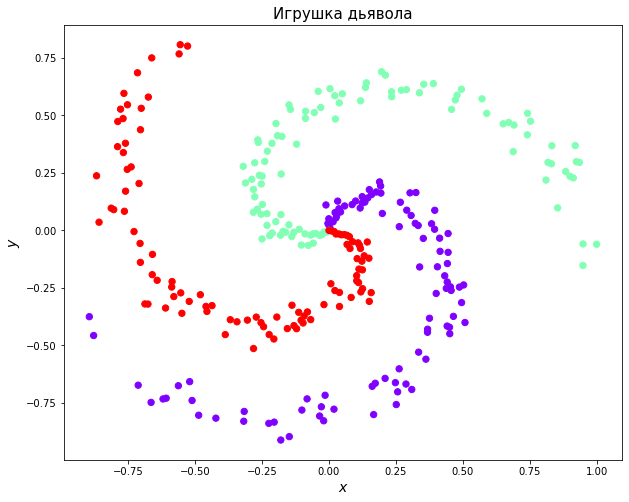

In [3]:
# Отрисовочная магия, сново взято из:
# http://cs213n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show()

In [4]:
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

In [7]:
# СЕТЬ С ПРОШЛОГО СЕМИНАРА

# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоев;
# D_out - размерность выходного слоя (суть - количество классов)
D_in, H, D_out = 2, 100, 3

# Use the nn package to define our model and loss function
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

In [8]:
# НОВАЯ СЕТЬ

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.f_lin = nn.Linear(D_in, H)
        self.s_lin = nn.Linear(H, D_out)

    def forward(self, X):
        X = F.relu(self.f_lin(X))
        return F.softmax(self.s_lin(X))

model = MyModule()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), 1e-1)

<ipython-input-8-ccf06b794dbc>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.s_lin(X))


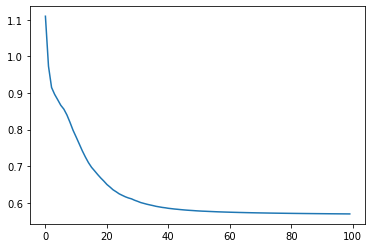

In [9]:
losses = []
for t in range(100):
    # forward
    y_pred = model(X)

    # loss
    loss = loss_fn(y_pred, y)
    losses.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

plt.plot(losses)

In [11]:
# Сеть без параметров
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = [nn.Linear(D_in, H), nn.Linear(H, D_out)]
        self.my_useless_bias = torch.ones(1, H, requires_grad=True)
        self.more_of_my_useless_biases = [
            torch.ones(1, H, requires_grad=True),
            torch.ones(1, H, requires_grad=True),
            torch.ones(1, H, requires_grad=True)
        ]
    
    def forward(self, X):
        X = F.relu(self.linear_layers[0](X))
        X += self.my_useless_bias
        return F.softmax(self.linear_layers[1](X))

model = MyModule()
list(model.parameters())

[]

In [12]:
# Исправленная сеть с параметрами

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = nn.ModuleList([nn.Linear(D_in, H), nn.Linear(H, D_out)])
        self.my_useless_bias = nn.Parameter(torch.ones(1, H, requires_grad=True))
        self.more_of_my_useless_biases = nn.ParameterList([
            nn.Parameter(torch.ones(1, H, requires_grad=True)),
            nn.Parameter(torch.ones(1, H, requires_grad=True)),
            nn.Parameter(torch.ones(1, H, requires_grad=True))
        ])
    
    def forward(self, X):
        X = F.relu(self.linear_layers[0](X))
        X += self.my_useless_bias
        for b in self.more_of_my_useless_biases:
            X += b
        return F.softmax(self.linear_layers[1](X))

model = MyModule()
list(model.parameters())

[Parameter containing:
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1501,  0.2027],
         [-0.2685, -0.0927],
         [ 0.3873, -0.5890],
         [-0.4552,  0.5863],
         [-0.1578, -0.4557],
         [-0.2474, -0.6144],
         [ 0.5369,  0.6680],
         [ 0.1621, -0.2240],
         [-0.4819, -0.3056],
         [ 0.6113, -0.1476],
         [-0.4030, -0.2363],
         [-0.0101, -0.6942],
         [ 0.4517,  0.2413],
         [-0.0597, -0.6015],
         [ 0.5423,  0.4309],
         [-0.1462, -0.5569],
       